In [184]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import DepthwiseConv2D as OriginalDepthwiseConv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [185]:

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [186]:

# Caso precise de camada personalizada para lidar com 'groups' em DepthwiseConv2D:
class CustomDepthwiseConv2D(OriginalDepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        if 'groups' in kwargs:
            kwargs.pop('groups')
        super(CustomDepthwiseConv2D, self).__init__(*args, **kwargs)

# Dicionário para carregar o modelo com a camada customizada
custom_objects = {'DepthwiseConv2D': CustomDepthwiseConv2D}

In [187]:

# Caminho do modelo exportado (ajuste conforme necessário)
model_path = "./content/model.h5"

# Carregar o modelo
model = load_model(model_path, custom_objects=custom_objects)
print("Modelo carregado com sucesso!")

# Compilar o modelo para classificação binária
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("Modelo compilado!")

Modelo carregado com sucesso!
Modelo compilado!


## **Configurar Geradores de Dados**

Abaixo, definimos:

-   **train_data_dir**: caminho para as imagens de treinamento
    (subpastas `gato` e `caes`).
-   **validation_data_dir**: caminho para as imagens de validação.
-   **test_data_dir**: caminho para as imagens de teste.

Também aplicamos *data augmentation* no conjunto de treinamento para
melhorar a capacidade de generalização do modelo.

In [188]:
# Ajuste conforme seu dataset
train_data_dir = "./content/train"       # pastas: gato/, caes/
validation_data_dir = "./content/validate" # pastas: gato/, caes/
test_data_dir = "./content/test_data"         # pastas: gato/, caes/

class_names = ['dogs', 'cats']

img_height, img_width = 224, 224
batch_size = 32

# Data augmentation para o conjunto de treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    shuffle=True
)

# Sem augmentation para validação e teste
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    shuffle=False
)

print("\nClasses (train):", train_generator.class_indices)
print("Classes (validation):", validation_generator.class_indices)
print("Classes (test):", test_generator.class_indices)

Found 19998 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.

Classes (train): {'dogs': 0, 'cats': 1}
Classes (validation): {'dogs': 0, 'cats': 1}
Classes (test): {'dogs': 0, 'cats': 1}


## **Fine-Tuning**

Descongelamos as últimas camadas do modelo para ajustar os pesos de
forma mais profunda, usando uma taxa de aprendizado menor. Em seguida,
treinamos o modelo com *early stopping* e redução de taxa de aprendizado
(via `ReduceLROnPlateau`).

In [189]:
# Congela todas as camadas inicialmente
for layer in model.layers:
    layer.trainable = False

# Descongela as últimas 5 camadas
for layer in model.layers[-5:]:
    layer.trainable = True

# Recompile o modelo com LR menor
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("Modelo recompilado para fine-tuning!")

Modelo recompilado para fine-tuning!


In [190]:

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7)
checkpoint = ModelCheckpoint("fine_tuned_model.h5", monitor='val_accuracy', save_best_only=True)

In [191]:
print(f"Número de amostras no train_generator: {train_generator.samples}")
print(f"Número de amostras no validation_generator: {validation_generator.samples}")


Número de amostras no train_generator: 19998
Número de amostras no validation_generator: 4998


In [192]:

# Treinamento
epochs = 10  # Ajuste conforme necessário
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.3057 - loss: 7.4311

/Users/kalebeandrade/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 217s 335ms/step - accuracy: 0.3060 - loss: 7.4256 - val_accuracy: 0.5942 - val_loss: 2.0597 - learning_rate: 1.0000e-05
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7652 - loss: 0.9118

625/625 ━━━━━━━━━━━━━━━━━━━━ 226s 362ms/step - accuracy: 0.7652 - loss: 0.9116 - val_accuracy: 0.7941 - val_loss: 0.7898 - learning_rate: 1.0000e-05
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8358 - loss: 0.5487

625/625 ━━━━━━━━━━━━━━━━━━━━ 226s 362ms/step - accuracy: 0.8358 - loss: 0.5487 - val_accuracy: 0.8567 - val_loss: 0.5030 - learning_rate: 1.0000e-05
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8662 - loss: 0.3954

625/625 ━━━━━━━━━━━━━━━━━━━━ 225s 360ms/step - accuracy: 0.8662 - loss: 0.3953 - val_accuracy: 0.8856 - val_loss: 0.3777 - learning_rate: 1.0000e-05
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.8913 - loss: 0.2996

625/625 ━━━━━━━━━━━━━━━━━━━━ 215s 344ms/step - accuracy: 0.8913 - loss: 0.2997 - val_accuracy: 0.9036 - val_loss: 0.3022 - learning_rate: 1.0000e-05
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9031 - loss: 0.2629

625/625 ━━━━━━━━━━━━━━━━━━━━ 218s 349ms/step - accuracy: 0.9031 - loss: 0.2629 - val_accuracy: 0.9174 - val_loss: 0.2504 - learning_rate: 1.0000e-05
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9093 - loss: 0.2387

625/625 ━━━━━━━━━━━━━━━━━━━━ 212s 339ms/step - accuracy: 0.9093 - loss: 0.2387 - val_accuracy: 0.9282 - val_loss: 0.2166 - learning_rate: 1.0000e-05
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9203 - loss: 0.2045

625/625 ━━━━━━━━━━━━━━━━━━━━ 219s 350ms/step - accuracy: 0.9203 - loss: 0.2045 - val_accuracy: 0.9346 - val_loss: 0.1937 - learning_rate: 1.0000e-05
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9273 - loss: 0.1852

625/625 ━━━━━━━━━━━━━━━━━━━━ 219s 351ms/step - accuracy: 0.9273 - loss: 0.1852 - val_accuracy: 0.9412 - val_loss: 0.1760 - learning_rate: 1.0000e-05
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9343 - loss: 0.1623

625/625 ━━━━━━━━━━━━━━━━━━━━ 215s 344ms/step - accuracy: 0.9343 - loss: 0.1623 - val_accuracy: 0.9444 - val_loss: 0.1614 - learning_rate: 1.0000e-05


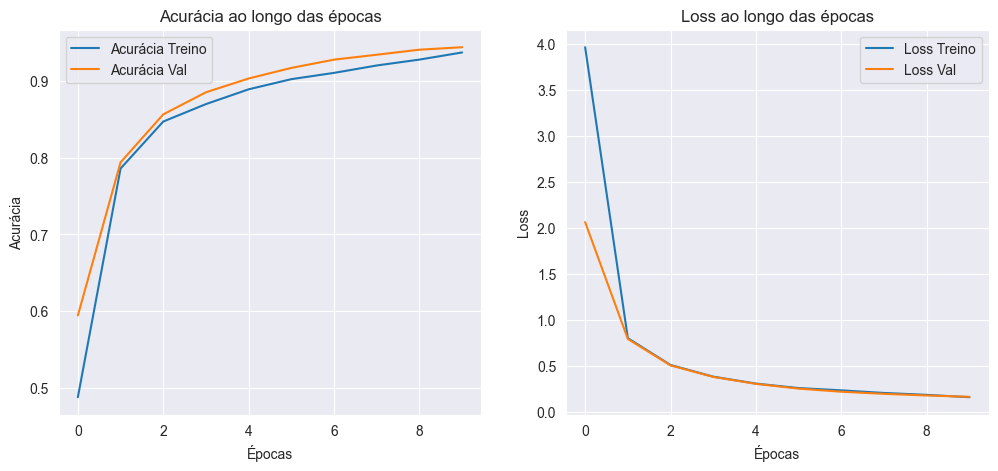

In [193]:

# Plotar curvas de treino
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Val')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Acurácia ao longo das épocas')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Val')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss ao longo das épocas')
plt.show()

## **Avaliação no Conjunto de Teste**

Após o fine-tuning, vamos avaliar o modelo no conjunto de teste e gerar:

-   Acurácia
-   Matriz de Confusão
-   Relatório de Classificação (precisão, recall, F1)
-   Scatter Plot (com jitter) para visualizar onde cada ponto foi
    classificado.

In [194]:
# Avaliação no teste
test_generator.reset()
loss_ft, accuracy_ft = model.evaluate(test_generator, verbose=1)
print(f"Acurácia após fine-tuning (teste): {accuracy_ft:.2f}")

# Obter previsões
predictions = model.predict(test_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Rótulos reais
true_classes = test_generator.classes

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9564 - loss: 0.1050
Acurácia após fine-tuning (teste): 0.95
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step


In [195]:
# Verificação inicial do tamanho das listas
print(f'Tamanho de true_classes: {len(true_classes)}')
print(f'Tamanho de predicted_classes: {len(predicted_classes)}')

# Corrigindo tamanhos inconsistentes
if len(true_classes) != len(predicted_classes):
    min_length = min(len(true_classes), len(predicted_classes))
    print(f"Ajustando os tamanhos: cortando as listas para {min_length} elementos.")
    true_classes = true_classes[:min_length]
    predicted_classes = predicted_classes[:min_length]


Tamanho de true_classes: 2023
Tamanho de predicted_classes: 4046
Ajustando os tamanhos: cortando as listas para 2023 elementos.


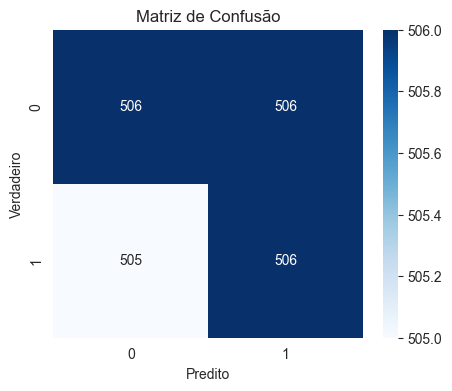

Relatório de Classificação:
              precision    recall  f1-score   support

        caes       0.50      0.50      0.50      1012
        gato       0.50      0.50      0.50      1011

    accuracy                           0.50      2023
   macro avg       0.50      0.50      0.50      2023
weighted avg       0.50      0.50      0.50      2023



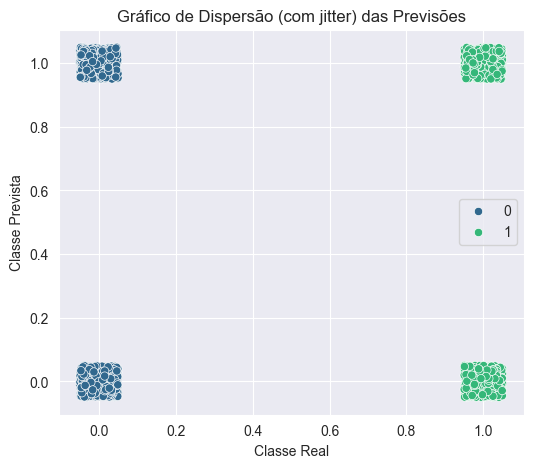

In [196]:

# Matriz de Confusão
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()


# Relatório de Classificação
print("Relatório de Classificação:")
print(classification_report(true_classes, predicted_classes, target_names=['caes','gato']))

# Scatter Plot (com jitter)
x_jitter = true_classes + np.random.uniform(-0.05, 0.05, size=len(true_classes))
y_jitter = predicted_classes + np.random.uniform(-0.05, 0.05, size=len(predicted_classes))

plt.figure(figsize=(6,5))
sns.scatterplot(x=x_jitter, y=y_jitter, hue=true_classes, palette='viridis')
plt.xlabel('Classe Real')
plt.ylabel('Classe Prevista')
plt.title('Gráfico de Dispersão (com jitter) das Previsões')
plt.show()

## **Previsão em Imagem Individual (Opcional)**

Se desejar testar o modelo em uma única imagem, você pode usar a função
abaixo.

In [197]:
print("Classes encontradas:", test_generator.class_indices)

Classes encontradas: {'dogs': 0, 'cats': 1}


In [198]:


def predict_single_image(img_path, model, target_size=(224, 224)):
    """
    Carrega uma imagem individual e faz previsão usando o modelo.
    Para classificação binária, assume que o modelo retorna probabilidade única.
    """
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    pred_matrix = (pred > 0.5).astype("int32").flatten()
    if np.array_equal(pred_matrix, [1, 0]):
        return "Cachorro"
    elif np.array_equal(pred_matrix, [0, 1]):
        return "Gato"
    else:
        return "Desconhecido"

In [199]:
import os

test_path = "./content/test_outher"

result_list = []

for img in os.listdir(test_path):
    img_path = os.path.join(test_path, img)
    resultado = predict_single_image(img_path, model)
    result_list.append((img, resultado))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


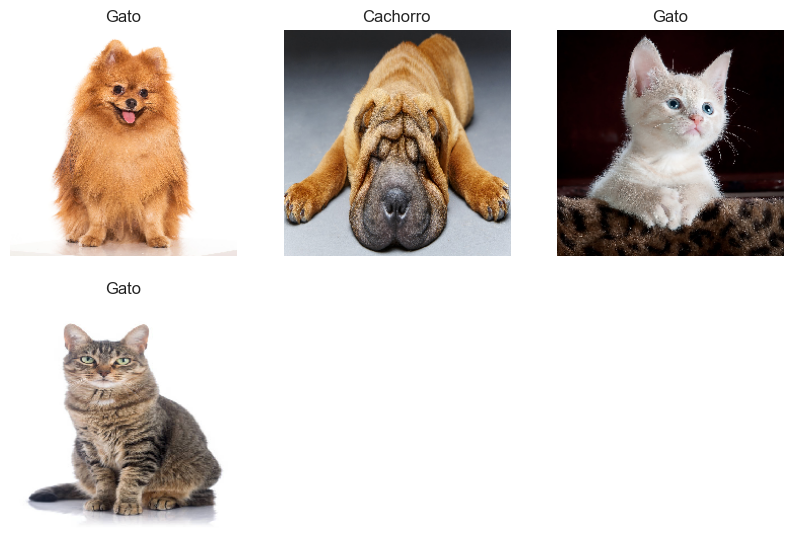

In [200]:
# Exibir graficamente os resultados
plt.figure(figsize=(10, 10))
for i, (img, result) in enumerate(result_list):
    plt.subplot(3, 3, i + 1)
    img = load_img(os.path.join(test_path, img), target_size=(224, 224))
    plt.imshow(img)
    plt.title(result)
    plt.axis("off")
plt.show()
